Vision Transformer:
https://huggingface.co/docs/transformers/model_doc/vit

DS:
https://www.vcl.fer.hr/comofod/



https://github.com/isi-vista/BusterNet

* هذا الكود الذي واجهنا فيه مشكلة تعارض المكتبات:
https://colab.research.google.com/drive/1Hnjq6K8LEuCJRnLmd-3qvPp73QjEVdTi?usp=sharing

* وهذا هو الكود الذي خرجت معنا نتائج نسبة دقتها قليلة:
https://colab.research.google.com/drive/1g7ZG-V9jtj58jHobnsUcEYNLMJmpO0Hj

* هنا رابط ملف Google Drive فيه جميع التجارب:
https://drive.google.com/drive/folders/1tDKaUW2v4twNkyJykAHb9QYDN_c7z48N

* مصدر إضافي يمكن الاطلاع عليه: ورقة علمية مستخدمين الVision Transformer مع ال Manipulation Detection للصور.
هنا رابطها:
https://openaccess.thecvf.com/content/CVPR2021W/WMF/papers/Horvath_Manipulation_Detection_in_Satellite_Images_Using_Vision_Transformer_CVPRW_2021_paper.pdf


https://viso.ai/deep-learning/vision-transformer-vit/



#DS

CoMoFoD database for a copy-move forgery detection consist of 260 forged image sets in two categories (small 512x512, and large 3000x2000). Images are grouped in 5 groups according to applied manipulation: translation, rotation, scaling, combination and distortion. Different types of postprocessing methods, such as JPEG compression, blurring, noise adding, color reduction etc., are applied to all forged and original images.

In [1]:
import urllib.request

url = "https://www.vcl.fer.hr/comofod/comofod_small.rar"

filename = "comofod_small.rar"

urllib.request.urlretrieve(url, filename)

print("Dataset Downloaded Successfully!")

Dataset Downloaded Successfully!


In [2]:
!pip install patool

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.5/77.5 KB 6.4 MB/s eta 0:00:00


In [3]:
import patoolib
patoolib.extract_archive(filename, outdir="/content")

print("Dataset Extracted Successfully!")

patool: Extracting comofod_small.rar ...
patool: running /usr/bin/unrar x -- /content/comofod_small.rar
patool:     with cwd='/content'
patool: ... comofod_small.rar extracted to `/content'.
Dataset Extracted Successfully!


512 x 512,
200 image sets,
40 images per transformation type,
total number of images with postprocessed images = 10400.
each Image in the Dataset is represented as follows:
imag index_B/F/M/O_version

#Preprocessing 

This class assumes that the CoMoFoD dataset is organized into two subdirectories, copy-move and non-copy-move, each containing the corresponding images with filenames in the format {label}_x_y.jpg, where {label} is either cf for copy-move or nc for non-copy-move, and x and y are integers.

The __init__ method of the class initializes the class variables self.image_paths and self.labels by iterating over the dataset directory and extracting the image paths and labels from the filenames.

The __len__ method returns the total number of images in the dataset, while the __getitem__ method loads the image and its corresponding label at the specified index. The image is loaded using OpenCV and converted to RGB format. If a data augmentation transform is specified, it is applied to the image. The image is then transposed to have channels as the first dimension and normalized to have values between 0 and 1. The label is returned as a single integer (0 for non-copy-move and 1 for copy-move).

In [4]:
import os
import cv2
import numpy as np
from torch.utils.data import Dataset
from torchvision import transforms
from matplotlib import pyplot as plt
from skimage import io
import skimage
import numpy as np
%matplotlib inline
from google.colab.patches import cv2_imshow
from PIL import Image
from itertools import product
import shutil

In [5]:

class CoMoFoDDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []
        print(os.listdir(data_dir))
        for file_name in os.listdir(data_dir):
          if file_name.endswith('.jpg') or file_name.endswith('.png'):
            file_path = os.path.join(r"/content/CoMoFoD_small_v2", file_name)
            print(file_path)
            self.image_paths.append(file_path)
            self.labels.append(int(file_name.split('_')[0] == 'cf'))
                      
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform is not None:
            image = self.transform(image=image)['image']
        image = np.transpose(image, (2, 0, 1))
        image = (image / 255.0).astype(np.float32)
        return image, label


In [6]:

data_dir = '/content/CoMoFoD_small_v2'
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

dataset = CoMoFoDDataset(data_dir, transform=transform)
len(dataset)

Streaming output truncated to the last 5000 lines.
/content/CoMoFoD_small_v2/157_F_JC2.jpg
/content/CoMoFoD_small_v2/038_F_BC3.png
/content/CoMoFoD_small_v2/064_O_JC9.jpg
/content/CoMoFoD_small_v2/113_F_IB2.png
/content/CoMoFoD_small_v2/074_F_BC1.png
/content/CoMoFoD_small_v2/129_F_CR1.png
/content/CoMoFoD_small_v2/023_O_JC3.jpg
/content/CoMoFoD_small_v2/107_F_JC7.jpg
/content/CoMoFoD_small_v2/127_F_CR3.png
/content/CoMoFoD_small_v2/063_F_IB2.png
/content/CoMoFoD_small_v2/002_M.png
/content/CoMoFoD_small_v2/025_F_JC1.jpg
/content/CoMoFoD_small_v2/149_F_CR3.png
/content/CoMoFoD_small_v2/141_F.png
/content/CoMoFoD_small_v2/157_O_JC4.jpg
/content/CoMoFoD_small_v2/097_O_JC7.jpg
/content/CoMoFoD_small_v2/092_F_BC1.png
/content/CoMoFoD_small_v2/049_F_JC4.jpg
/content/CoMoFoD_small_v2/044_F_BC2.png
/content/CoMoFoD_small_v2/028_F_IB2.png
/content/CoMoFoD_small_v2/162_B.png
/content/CoMoFoD_small_v2/048_F_BC2.png
/content/CoMoFoD_small_v2/114_F_CA2.png
/content/CoMoFoD_small_v2/041_O_BC3.png
/

10400

This code initializes a CoMoFoDDataset object with the specified dataset directory and data augmentation transform. It resizes the images to 224x224, applies random horizontal flips, and converts the images to PyTorch tensors. You can modify the transform to include additional data augmentation techniques if needed.

In [7]:
data_dir = r"/content/CoMoFoD_small_v2"
images_names_list = os.listdir(data_dir)
print(images_names_list)

['014_F_JC8.jpg', '034_F_JC1.jpg', '090_F_JC7.jpg', '064_O_JC6.jpg', '035_F_CR1.png', '159_F_BC1.png', '037_F_BC2.png', '165_O_CA2.png', '002_F_JC9.jpg', '129_O_BC3.png', '094_O_CA2.png', '008_O_JC2.jpg', '145_O_BC1.png', '014_F_CA3.png', '086_F_JC4.jpg', '085_F_BC1.png', '064_F_JC8.jpg', '168_O_NA1.png', '157_O_CR3.png', '116_O_JC3.jpg', '041_O_BC1.png', '156_F_JC5.jpg', '147_F_CA2.png', '001_O_JC7.jpg', '073_F_CA3.png', '136_F_JC1.jpg', '103_O_CA2.png', '069_F_JC3.jpg', '106_O_IB3.png', '127_B.png', '035_F_NA1.png', '054_O_CA3.png', '041_F_CR2.png', '010_O.png', '119_F_NA1.png', '090_F_BC3.png', '103_O_JC1.jpg', '126_O_CR3.png', '007_O_NA2.png', '087_O_IB2.png', '146_F_CA3.png', '034_F_BC3.png', '087_F_JC2.jpg', '139_F_BC3.png', '137_F_JC2.jpg', '025_O_JC1.jpg', '048_F_CA3.png', '050_F_CA2.png', '101_F_JC4.jpg', '060_F_CA2.png', '195_F_NA2.png', '024_O_IB3.png', '087_F_CA3.png', '095_O_CR1.png', '044_O_JC2.jpg', '009_F.png', '064_M.png', '063_O_NA1.png', '043_F_NA2.png', '146_O_CR1.p

In [8]:
os.mkdir("/content/original")
os.mkdir("/content/forged")
os.mkdir("/content/M")
os.mkdir("/content/B")

In [9]:
'/content/CoMoFoD_small_v2/001_M.png'.split(".")[0].split("_")[-1]

'M'

In [10]:
for file_n in images_names_list:

  ext = "." + file_n.split(".")[1]
  if file_n.split(".")[0].split("_")[-1] == 'F':
    dst_dir = r"/content/forged"
  elif file_n.split(".")[0].split("_")[-1] == "O":
    dst_dir = r"/content/original"
  elif file_n.split(".")[0].split("_")[-1] == "M": 
    dst_dir = r"/content/M"
  elif file_n.split(".")[0].split("_")[-1] == "B":
    dst_dir = r"/content/B"
  else:
    continue
  
  src_dir = r"/content/CoMoFoD_small_v2/" + file_n
  shutil.move(src_dir,dst_dir)

#Model (Vision Transformer) - Classification

In [11]:
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import os

# used to supress display of warnings
import warnings

from sklearn.metrics import precision_recall_curve,accuracy_score,f1_score,precision_score,recall_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ZeroPadding2D, Convolution2D, MaxPooling2D, Dropout, Flatten, Activation, Dense

from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical 
from keras import  models
from keras.utils import to_categorical
from tensorflow.keras.models import Model
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.layers import Dense
from tensorflow.keras.applications import VGG16
import joblib
import torch.utils.data as data
from torch.autograd import Variable
import numpy as np


##split the data

In [12]:
# Define the root directory of the dataset
root_dir = "/content"

# Define the subdirectories of the dataset
sub_dirs = ["original", "forged"]
# Define the percentage of data to be used for training, validation, and testing
train_pct = 0.8
val_pct = 0.1
test_pct = 0.1

In [13]:

# Create the subdirectories for training, validation, and testing
for sub_dir in sub_dirs:
    os.makedirs(os.path.join(root_dir, "train", sub_dir), exist_ok=True)
    os.makedirs(os.path.join(root_dir, "val", sub_dir), exist_ok=True)
    os.makedirs(os.path.join(root_dir, "test", sub_dir), exist_ok=True)

# Iterate over each subdirectory and split the data into training, validation, and testing sets
for sub_dir in sub_dirs:
    file_list = os.listdir(os.path.join(root_dir, sub_dir))
    train_files, val_test_files = train_test_split(file_list, train_size=train_pct, random_state=42)
    val_files, test_files = train_test_split(val_test_files, train_size=val_pct/(val_pct+test_pct), random_state=42)
    
    # Move the training files
    for file_name in train_files:
        src_file_path = os.path.join(root_dir, sub_dir, file_name)
        dst_file_path = os.path.join(root_dir, "train", sub_dir, file_name)
        shutil.copy(src_file_path, dst_file_path)
    
    # Move the validation files
    for file_name in val_files:
        src_file_path = os.path.join(root_dir, sub_dir, file_name)
        dst_file_path = os.path.join(root_dir, "val", sub_dir, file_name)
        shutil.copy(src_file_path, dst_file_path)
    
    # Move the testing files
    for file_name in test_files:
        src_file_path = os.path.join(root_dir, sub_dir, file_name)
        dst_file_path = os.path.join(root_dir, "test", sub_dir, file_name)
        shutil.copy(src_file_path, dst_file_path)
        # move(src_file_path, dst_file_path)

## Define the Model

To train this model, we will train in 3 epochs, with a batch size of 10 and a learning rate of 2e-5:

In [15]:
img_width, img_height = 224, 224
batch_size = 128
epochs = 10

In [14]:
num_classes = len(os.listdir(r'/content/train'))
num_classes

2

In [16]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 33.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 20.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 29.7 MB/s eta 0:00:00


In [17]:
!pip install -q git+https://github.com/huggingface/transformers

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


Next, convert the folder structure dataset into a PyTorch dataset format using PyTorch's ImageFolder dataset structure:


The model itself uses a linear layer on top of a pre-trained `ViTModel`. We place a linear layer on top of the last hidden state of the [CLS] token, which serves as a good representation of an entire image. We also add dropout for regularization.

**Note:** The Vision Transformer pretrained model can be used as a regular PyTorch layer.

In [18]:
from transformers import ViTModel
from transformers.modeling_outputs import SequenceClassifierOutput
import torch.nn as nn
import torch.nn.functional as F

class ViTForImageClassification(nn.Module):
    def __init__(self, num_labels=3):
        super(ViTForImageClassification, self).__init__()
        self.vit = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(self.vit.config.hidden_size, num_labels)
        self.num_labels = num_labels

    def forward(self, pixel_values, labels):
        outputs = self.vit(pixel_values=pixel_values)
        output = self.dropout(outputs.last_hidden_state[:,0])
        logits = self.classifier(output)

        loss = None
        if labels is not None:
          loss_fct = nn.CrossEntropyLoss()
          loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
        if loss is not None:
          return logits, loss.item()
        else:
          return logits, None

In [19]:
import torchvision
from torchvision.transforms import ToTensor

train_ds = torchvision.datasets.ImageFolder('/content/train/', transform=ToTensor())
valid_ds = torchvision.datasets.ImageFolder('/content/val/', transform=ToTensor())
test_ds = torchvision.datasets.ImageFolder('/content/test/', transform=ToTensor())

In [20]:
EPOCHS = 9
BATCH_SIZE = 10
LEARNING_RATE = 2e-7

We will use the pretrained Vision Transformer feature extractor, an Adam Optimizer, and a Cross Entropy Loss function.

In [21]:
from transformers import ViTFeatureExtractor
import torch.nn as nn
import torch
# Define Model
model = ViTForImageClassification(len(train_ds.classes))    
# Feature Extractor
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')
# Adam Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
# Cross Entropy Loss
loss_func = nn.CrossEntropyLoss()
# Use GPU if available  
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
if torch.cuda.is_available():
    model.cuda() 

/usr/local/lib/python3.9/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [22]:
from sklearn.metrics import precision_score, recall_score, f1_score

import warnings
warnings.filterwarnings('ignore')

print("Number of train samples: ", len(train_ds))
print("Number of valid samples: ", len(valid_ds))
print("Number of test samples: ", len(test_ds))
print("Detected Classes are: ", train_ds.class_to_idx) 

train_loader = data.DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=4)
test_loader  = data.DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=4) 


Number of train samples:  320
Number of valid samples:  40
Number of test samples:  40
Detected Classes are:  {'forged': 0, 'original': 1}


## Train the Model

In [ ]:
#New one
# Train the model
for epoch in range(EPOCHS):
    for step, (x, y) in enumerate(train_loader):
        # Change input array into list with each batch being one element
        x = np.split(np.squeeze(np.array(x)), BATCH_SIZE)
        # Remove unnecessary dimension
        for index, array in enumerate(x):
            x[index] = np.squeeze(array)
        # Apply feature extractor, stack back into 1 tensor and then convert to tensor
        x = torch.tensor(np.stack(feature_extractor(x)['pixel_values'], axis=0))
        # Send to GPU if available
        x, y  = x.to(device), y.to(device)
        b_x = Variable(x)   # batch x (image)
        b_y = Variable(y)   # batch y (target)
        # Feed through model
        output, loss = model(b_x, None)
        # Calculate loss
        if loss is None: 
            loss = loss_func(output, b_y)   
            optimizer.zero_grad()           
            loss.backward()                 
            optimizer.step()

        if step % 50 == 0:
            # Get the next batch for testing purposes
            test = next(iter(test_loader))
            test_x = test[0]
            # Reshape and get feature matrices as needed
            test_x = np.split(np.squeeze(np.array(test_x)), BATCH_SIZE)
            for index, array in enumerate(test_x):
                test_x[index] = np.squeeze(array)
            test_x = torch.tensor(np.stack(feature_extractor(test_x)['pixel_values'], axis=0))
            # Send to appropriate computing device
            test_x = test_x.to(device)
            test_y = test[1].to(device)
            # Get output (+ respective class) and compare to target
            test_output, loss = model(test_x, test_y)
            test_output = test_output.argmax(1)
            # Calculate evaluation metrics
            tp = ((test_output == 1) & (test_y == 1)).sum().item()
            fp = ((test_output == 1) & (test_y == 0)).sum().item()
            tn = ((test_output == 0) & (test_y == 0)).sum().item()
            fn = ((test_output == 0) & (test_y == 1)).sum().item()
            precision = precision_score(test_y.cpu().numpy(), test_output.cpu().numpy())
            recall = recall_score(test_y.cpu().numpy(), test_output.cpu().numpy())
            f1 = f1_score(test_y.cpu().numpy(), test_output.cpu().numpy())
            
            # Calculate Accuracy
            accuracy = (test_output == test_y).sum().item() / BATCH_SIZE
            print('Epoch: ', epoch, '| train loss: %.4f' % loss , '| test accuracy: %.4f' % accuracy, '| test precision: %.4f' % precision, '| test recall: %.4f' % recall, '| test F1 score: %.4f' % f1)


Number of train samples:  320
Number of test samples:  40
Detected Classes are:  {'forged': 0, 'original': 1}
Epoch:  0 | train loss: 0.6816 | test accuracy: 0.7000 | test precision: 0.6000 | test recall: 0.7500 | test F1 score: 0.6667
Epoch:  1 | train loss: 0.6857 | test accuracy: 0.5000 | test precision: 0.5714 | test recall: 0.6667 | test F1 score: 0.6154
Epoch:  2 | train loss: 0.6764 | test accuracy: 0.6000 | test precision: 0.6667 | test recall: 0.6667 | test F1 score: 0.6667
Epoch:  3 | train loss: 0.6690 | test accuracy: 0.6000 | test precision: 0.3333 | test recall: 0.3333 | test F1 score: 0.3333
Epoch:  4 | train loss: 0.6746 | test accuracy: 0.6000 | test precision: 0.4000 | test recall: 0.6667 | test F1 score: 0.5000
Epoch:  5 | train loss: 0.7011 | test accuracy: 0.3000 | test precision: 0.2000 | test recall: 0.2500 | test F1 score: 0.2222
Epoch:  6 | train loss: 0.7072 | test accuracy: 0.2000 | test precision: 0.3333 | test recall: 0.1429 | test F1 score: 0.2000
Epoch:  

## Evaluate on a Test Image

tensor([0]) <class 'torch.Tensor'>
torch.Size([1, 3, 512, 512])


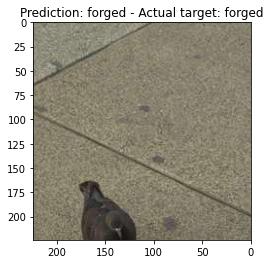

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

EVAL_BATCH = 1
eval_loader  = data.DataLoader(valid_ds, batch_size=EVAL_BATCH, shuffle=True, num_workers=4) 
# Disable grad
with torch.no_grad():
    
  inputs, target = next(iter(eval_loader))
  # Reshape and get feature matrices as needed
  print(target, type(target))
  print(inputs.shape)
  inputs = inputs[0].permute(1, 2, 0)
  # Save original Input
  originalInput = inputs
  for index, array in enumerate(inputs):
    inputs[index] = np.squeeze(array)
  inputs = torch.tensor(np.stack(feature_extractor(inputs)['pixel_values'], axis=0))

  # Send to appropriate computing device
  inputs = inputs.to(device)
  target = target.to(device)
 
  # Generate prediction
  prediction, loss = model(inputs, target)
    
  # Predicted class value using argmax
  predicted_class = np.argmax(prediction.cpu())
  value_predicted = list(valid_ds.class_to_idx.keys())[list(valid_ds.class_to_idx.values()).index(predicted_class)]
  value_target = list(valid_ds.class_to_idx.keys())[list(valid_ds.class_to_idx.values()).index(target)]
        
  # Show result
  plt.imshow(originalInput)
  plt.xlim(224,0)
  plt.ylim(224,0)
  plt.title(f'Prediction: {value_predicted} - Actual target: {value_target}')
  plt.show()

In [ ]:
gkgg = torch.tensor([0])
print(gkgg, type(gkgg))

tensor([0]) <class 'torch.Tensor'>


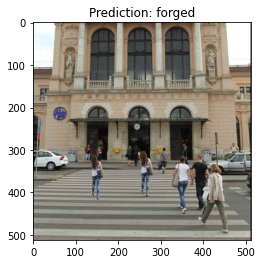

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

EVAL_BATCH = 1

# Load the image
image_path = '/content/forged/001_F_JC3.jpg'
image = Image.open(image_path).convert('RGB')

# Transform the image
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])
input_tensor = transform(image)
input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

# Send to appropriate computing device
input_batch = input_batch.to(device)

# Disable grad
with torch.no_grad():
    # Generate prediction
    #tensor([1](or) /[0](for)) <class 'torch.Tensor'>
    prediction, loss = model(input_batch, torch.tensor([0]))

# Predicted class value using argmax
predicted_class = np.argmax(prediction.cpu())
value_predicted = list(valid_ds.class_to_idx.keys())[list(valid_ds.class_to_idx.values()).index(predicted_class)]

# Show result
plt.imshow(image)
plt.title(f'Prediction: {value_predicted}')
plt.show()


##Classification model deployment

### Save the Entire Model

In [ ]:
torch.save(model, '/content/model.pt')

### Export Trained Model


In [ ]:
'''
from google.colab import drive
drive.mount('/content/gdrive')

%cp /content/model.pt /content/gdrive/My\ Drive
'''

Mounted at /content/gdrive


### Use the Exported Model

In [ ]:
MODEL_PATH = '/content/model.pt'
model2 = torch.load(MODEL_PATH)
model2.eval()

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0): ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_

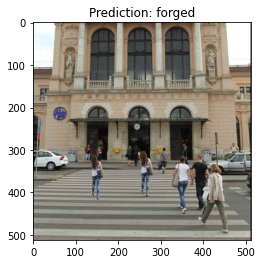

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

EVAL_BATCH = 1

# Load the image
image_path = '/content/forged/001_F_JC3.jpg'
image = Image.open(image_path).convert('RGB')

# Transform the image
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])
input_tensor = transform(image)
input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

# Send to appropriate computing device
input_batch = input_batch.to(device)

# Disable grad
with torch.no_grad():
    # Generate prediction
    #tensor([1](or) /[0](for)) <class 'torch.Tensor'>
    prediction, loss = model2(input_batch, torch.tensor([0]))

# Predicted class value using argmax
predicted_class = np.argmax(prediction.cpu())
value_predicted = list(valid_ds.class_to_idx.keys())[list(valid_ds.class_to_idx.values()).index(predicted_class)]

# Show result
plt.imshow(image)
plt.title(f'Prediction: {value_predicted}')
plt.show()


#Detection copy-move froged parts using ViT + Masked Autoencoder

the model accuracy is 83.664%

In [23]:
from transformers import ViTMAEForPreTraining

# make random mask reproducible (comment out to make it change)
torch.manual_seed(2)

model = ViTMAEForPreTraining.from_pretrained("facebook/vit-mae-base")
#model.eval()

In [24]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import save_image
from PIL import Image 
import PIL 
import cv2

imagenet_mean = np.array(feature_extractor.image_mean)
imagenet_std = np.array(feature_extractor.image_std)

def show_image(image, title=''):
    # image is [H, W, 3]
    assert image.shape[2] == 3
    plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())
    plt.title(title, fontsize=16)
    plt.axis('off')
    return

def visualize(pixel_values, model):
    # forward pass
    outputs = model(pixel_values)
    y = model.unpatchify(outputs.logits)
    y = torch.einsum('nchw->nhwc', y).detach().cpu()
    
    # visualize the mask
    mask = outputs.mask.detach()
    mask = mask.unsqueeze(-1).repeat(1, 1, model.config.patch_size**2 *3)  # (N, H*W, p*p*3)
    mask = model.unpatchify(mask)  # 1 is removing, 0 is keeping
    mask = torch.einsum('nchw->nhwc', mask).detach().cpu()
    
    x = torch.einsum('nchw->nhwc', pixel_values)

    # masked image
    im_masked = x * (1 - mask)

    # MAE reconstruction pasted with visible patches
    im_paste = x * (1 - mask) + y * mask

    # make the plt figure larger
    plt.rcParams['figure.figsize'] = [24, 24]

    plt.subplot(3, 2, 1)
    show_image(x[0], "original")

    plt.subplot(3, 2, 2)
    show_image(im_masked[0], "masked")

    plt.subplot(3, 2, 3)
    show_image(y[0], "reconstruction")

    plt.subplot(3, 2, 4)
    show_image(im_paste[0], "reconstruction + visible")

    difference_image = im_paste[0] - x[0]
    
    plt.subplot(3, 2, 5)
    show_image(difference_image , "Difference")
    
    # Save difference image to disk
    save_image(difference_image.permute(2,0,1), '/content/out/heatmap.jpg')

In [39]:

def visualize(pixel_values, model):
    # forward pass
    outputs = model(pixel_values)
    y = model.unpatchify(outputs.logits)
    y = torch.einsum('nchw->nhwc', y).detach().cpu()
    
    # visualize the mask
    mask = outputs.mask.detach()
    mask = mask.unsqueeze(-1).repeat(1, 1, model.config.patch_size**2 *3)  # (N, H*W, p*p*3)
    mask = model.unpatchify(mask)  # 1 is removing, 0 is keeping
    mask = torch.einsum('nchw->nhwc', mask).detach().cpu()
    
    x = torch.einsum('nchw->nhwc', pixel_values)

    # masked image
    im_masked = x * (1 - mask)

    # MAE reconstruction pasted with visible patches
    im_paste = x * (1 - mask) + y * mask

    # make the plt figure larger
    plt.rcParams['figure.figsize'] = [24, 24]

    plt.subplot(3, 2, 1)
    show_image(x[0], "original")

    plt.subplot(3, 2, 2)
    show_image(im_masked[0], "masked")

    plt.subplot(3, 2, 3)
    show_image(y[0], "reconstruction")

    plt.subplot(3, 2, 4)
    show_image(im_paste[0], "reconstruction + visible")

    difference_image = im_paste[0] - x[0]
    
    plt.subplot(3, 2, 5)
    show_image(difference_image , "Difference")
    import cv2
    import numpy as np

    # Convert difference_image to grayscale
    heatmap = cv2.cvtColor((difference_image.numpy() * 255).astype(np.uint8), cv2.COLOR_BGR2GRAY)
# Save difference image to disk
    save_image(difference_image.permute(2,0,1), '/content/out/heatmap_or.jpg')

    # Threshold heatmap to create binary image
    _, binary_heatmap = cv2.threshold(heatmap, 127, 255, cv2.THRESH_BINARY)

    # Apply morphological filters
    kernel = np.ones((7,7), np.uint8)
    opening = cv2.morphologyEx(binary_heatmap, cv2.MORPH_OPEN, kernel)
    closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel)

    # Save processed heatmap
    cv2.imwrite('/content/out/heatmap3.jpg', closing)
    

In [27]:
from transformers import ViTFeatureExtractor
import requests
from PIL import Image

feature_extractor = ViTFeatureExtractor.from_pretrained("facebook/vit-mae-base")


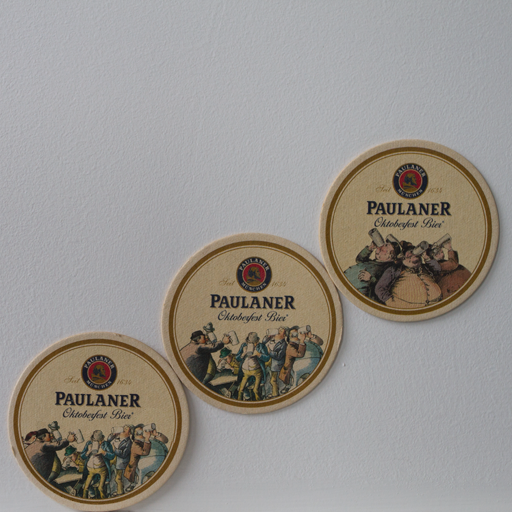

In [30]:
image = Image.open(r"/content/forged/005_F.png")
image

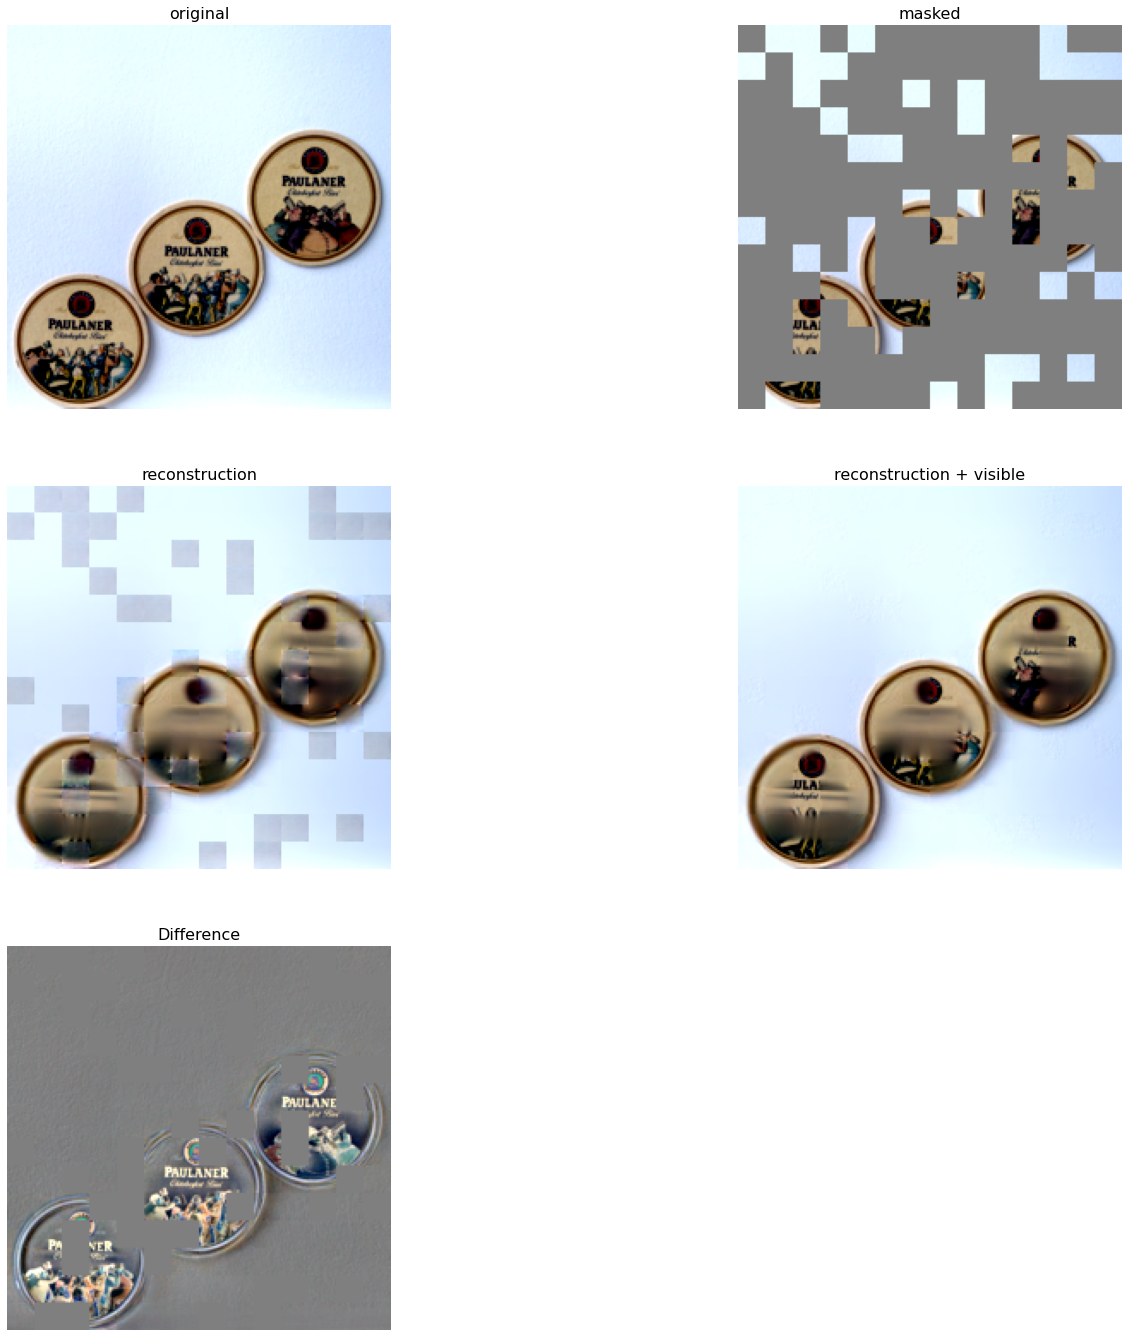

In [35]:
pixel_values = feature_extractor(image, return_tensors="pt").pixel_values
visualize(pixel_values, model)

Post-processing with morphological filters can be useful in detecting forged objects in images after reconstruction with an autoencoder. After reconstructing an image using an autoencoder, the difference between the original image and the reconstructed image can be used to create a heatmap that highlights the manipulated areas. However, this heatmap may contain noise or small regions that are not relevant to the detection of the forged object.

Morphological filters can be used to clean up the heatmap and improve the detection of the forged object. These filters work by applying mathematical operations to the binary heatmap to remove small regions or fill in gaps. For example, you could use morphological opening (erosion followed by dilation) to remove small regions or noise from the heatmap. Similarly, you could use morphological closing (dilation followed by erosion) to fill in gaps or connect disjoint regions in the heatmap.

#Detecting copy-move froged parts using image processing

In [ ]:
def tile(filename, dir_out, d):
    name, ext = os.path.splitext(filename.split("/")[-1])
    img = Image.open(os.path.join(filename))
    w, h = img.size
    
    grid = product(range(0, h-h%d, d), range(0, w-w%d, d))
    for i, j in grid:
        box = (j, i, j+d, i+d)
        out = os.path.join(dir_out, f'{name}_{i}_{j}' + '.png')
        img.crop(box).save(out)

In [ ]:
os.mkdir("/content/out")
tile('/content/CoMoFoD_small_v2/001_F_BC3.png', "/content/out", 100)

we will use BFMatcher.knnMatch() to get k best matches. In this example, we will take k=2 so that we can apply ratio test explained by D.Lowe in his paper.

In [ ]:
def show_images(images, titles):
    #This function is used to show image(s) with titles by sending an array of images and an array of associated titles.
    # images[0] will be drawn with the title titles[0] if exists
    # You aren't required to understand this function, use it as-is.
    assert len(images) == len(titles)
    images = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB) for img in images]
    fig = plt.figure()
    n_ims = len(images)
    n = 1
    for image,title in zip(images,titles):
        a = fig.add_subplot(1,n_ims,n)
        if image.ndim == 2: 
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
        n += 1
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_ims)
    plt.show() 

In [ ]:
# RGB
or_rgb = io.imread('/content/CoMoFoD_small_v2/001_F_BC3.png')
snip_rgb = io.imread('/content/out/001_F_BC3_300_200.png')

# Gray
or_gray = cv2.imread('/content/CoMoFoD_small_v2/001_F_BC3.png', 0)
snip_gray = cv2.imread('/content/out/001_F_BC3_300_200.png', 0)

In [ ]:
sift = cv2.xfeatures2d.SIFT_create()
# find the key points and descriptors with SIFT
kp_snip, des_snip = sift.detectAndCompute(snip_gray, None)
kp_or, des_or = sift.detectAndCompute(or_gray, None)

In [ ]:
match = cv2.BFMatcher()
matches = match.knnMatch(des_or, des_snip, k=2)

In [ ]:
good = []
for m,n in matches:
  if m.distance < 0.5*n.distance:
      good.append(m)

In [ ]:
type(good[0])

cv2.DMatch

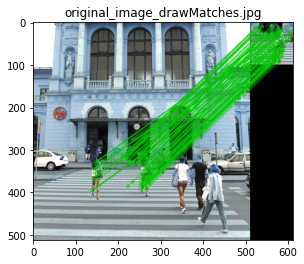

In [ ]:
draw_params = dict(matchColor = (0,200,0), # draw matches in green color
                   singlePointColor = None,
                   flags = 2)

matching_image = cv2.drawMatches(or_rgb, kp_or, snip_rgb, kp_snip, good, None, **draw_params)
show_images([matching_image], ['original_image_drawMatches.jpg'])

To make long story short, the keypoints are not stored in DMatch, but in the other list. DMatch object only stores the indices of matched keypoints, their distance and the index of the image. You can get this indices to get the keypoints from the other list.

In [ ]:
por = []
psnip = []
for matc in good:
  p1 = kp_or[matc.queryIdx].pt
  p2 = kp_snip[matc.trainIdx].pt
  por.append(p1)
  psnip.append(p2)

In [ ]:
import math
print(max(por), min(por))
x = max(por)
y = min(por)
distance = math.dist(x, y)
print("distance between detected objects is: ", distance)

(295.4757385253906, 321.4012756347656) (137.21206665039062, 395.4436340332031)
distance between detected objects is:  174.72738958892603


In [ ]:
#loop
data_dir = r"/content/out"
tiles_names_list = os.listdir(data_dir)
print(images_names_list)

['160_O_JC4.jpg', '015_F_CA3.png', '080_O_JC6.jpg', '158_F_BC3.png', '157_O_IB2.png', '147_B.png', '124_O_JC1.jpg', '011_M.png', '054_F.png', '049_O_IB3.png', '004_F_IB2.png', '122_O_CR3.png', '088_O_JC4.jpg', '003_O_IB3.png', '023_M.png', '018_F_BC1.png', '158_O_JC7.jpg', '076_O_JC8.jpg', '107_O_JC1.jpg', '043_F_IB2.png', '007_O_JC9.jpg', '051_O_CA3.png', '039_O_CR2.png', '056_O_BC2.png', '063_F_NA3.png', '095_F_JC5.jpg', '083_O_BC2.png', '021_F_JC4.jpg', '199_F_CA3.png', '084_F_CR3.png', '134_O_CR1.png', '157_F_JC4.jpg', '139_F_CA1.png', '078_O_BC1.png', '021_F_JC5.jpg', '040_F_BC3.png', '076_F_JC7.jpg', '031_B.png', '055_F_JC9.jpg', '137_F_JC9.jpg', '029_O_BC3.png', '151_F_IB1.png', '024_F_JC9.jpg', '013_O_CA1.png', '179_O_JC8.jpg', '038_O_CR3.png', '052_O_CA2.png', '084_F_NA2.png', '026_F_IB1.png', '098_F_BC3.png', '025_F_NA2.png', '059_O_JC1.jpg', '185_F_JC9.jpg', '112_F_NA1.png', '007_O_CA3.png', '102_O_CR1.png', '084_F_CA1.png', '031_M.png', '005_F_NA2.png', '197_O_CR3.png', '14

distance is:  259.8112137256002
distance is:  90.53621439573718
distance is:  161.2774161601733
distance is:  76.75347452025909
distance is:  83.30256025601805
distance is:  158.66998641640842
distance is:  85.99261693342224
distance is:  402.94319778743613
distance is:  241.76234744552747
distance is:  79.70812539807086
distance is:  85.93671269562252
distance is:  87.73654218192732
distance is:  269.60322704106267
distance is:  202.10228266550126
distance is:  108.71398548696823
distance is:  54.36069984043209
distance is:  87.49147287477595
distance is:  53.827597818471936
distance is:  94.24065042492143
distance is:  130.35203507903668
distance is:  158.76426069208537
distance is:  91.1888466041696
distance is:  232.42091367020066
distance is:  80.7579479034876
distance is:  249.70483133160425


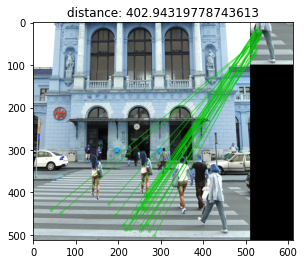

In [ ]:
largest_distance = 0
largest_distance_tile = ""

#target image
or_rgb = io.imread('/content/CoMoFoD_small_v2/001_F_BC3.png')
or_gray = cv2.imread('/content/CoMoFoD_small_v2/001_F_BC3.png', 0)


sift = cv2.xfeatures2d.SIFT_create()
match = cv2.BFMatcher()

for tile in tiles_names_list:


  # RGB
  snip_rgb = io.imread('/content/out/' + tile)

  # Gray
  snip_gray = cv2.imread('/content/out/' + tile, 0)

  # find the key points and descriptors with SIFT
  kp_snip, des_snip = sift.detectAndCompute(snip_gray, None)
  kp_or, des_or = sift.detectAndCompute(or_gray, None)

  
  matches = match.knnMatch(des_or, des_snip, k=2)

  good = []
  for m,n in matches:
    if m.distance < 0.4*n.distance:
        good.append(m)
      
      
  draw_params = dict(matchColor = (0,200,0), # draw matches in green color
                    singlePointColor = None,
                    flags = 2)

  por = []
  psnip = []
  for matc in good:
    p1 = kp_or[matc.queryIdx].pt
    p2 = kp_snip[matc.trainIdx].pt
    por.append(p1)
    psnip.append(p2)

  x = max(por)
  y = min(por)
  distance = math.dist(x, y)
  if distance > largest_distance:
    largest_distance_tile = tile
    largest_distance = distance
  print("distance is: ", distance)

#for the target tile (highest distance)

snip_rgb = io.imread('/content/out/' + largest_distance_tile)
snip_gray = cv2.imread('/content/out/' + largest_distance_tile, 0)
kp_snip, des_snip = sift.detectAndCompute(snip_gray, None)

matching_image = cv2.drawMatches(or_rgb, kp_or, snip_rgb, kp_snip, good, None, **draw_params)
show_images([matching_image], [f'distance: {largest_distance}'])

## Make it for another snip

In [ ]:
snip_rgb = io.imread('/content/out/001_F_BC3_200_200.png')

# Gray
snip_gray = cv2.imread('/content/out/001_F_BC3_200_200.png', 0)

In [ ]:
sift = cv2.xfeatures2d.SIFT_create()
# find the key points and descriptors with SIFT
kp_snip, des_snip = sift.detectAndCompute(snip_gray, None)
kp_or, des_or = sift.detectAndCompute(or_gray, None)

In [ ]:
match = cv2.BFMatcher()
matches = match.knnMatch(des_or, des_snip, k=2)

In [ ]:
good = []
for m,n in matches:
  if m.distance < 0.5*n.distance:
      good.append(m)

In [ ]:
type(good[0])

cv2.DMatch

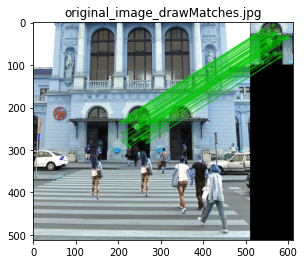

In [ ]:
draw_params = dict(matchColor = (0,200,0), # draw matches in green color
                   singlePointColor = None,
                   flags = 2)

matching_image = cv2.drawMatches(or_rgb, kp_or, snip_rgb, kp_snip, good, None, **draw_params)
show_images([matching_image], ['original_image_drawMatches.jpg'])

To make long story short, the keypoints are not stored in DMatch, but in the other list. DMatch object only stores the indices of matched keypoints, their distance and the index of the image. You can get this indices to get the keypoints from the other list.

In [ ]:
por = []
psnip = []
for matc in good:
  p1 = kp_or[matc.queryIdx].pt
  p2 = kp_snip[matc.trainIdx].pt
  por.append(p1)
  psnip.append(p2)

In [ ]:
import math
print(max(por), min(por))
x = max(por)
y = min(por)
print("distance between detected objects is: ", math.dist(x, y))

(286.7442321777344, 234.1744384765625) (207.03627014160156, 234.0130615234375)
distance between detected objects is:  79.70812539807086
